# Local NPP model hyperparams exploration (sklearn)

This notebook mirrors the GGE serverside training, but trains Random Forest models locally with scikit-learn. It:
- fetches training samples from GEE once (cached locally)
- performs the same spatial block train/test split
- visualizes train/validation/buffer-excluded samples

In [30]:
import os
import random

import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Earth Engine
ee.Initialize(project="landler-open-data")

# Asset paths
GEE_ASSET_ROOT = "projects/landler-open-data/assets/eii/intermediate/functional"
TRAINING_ASSET_PATH = f"{GEE_ASSET_ROOT}/training/final_reference_samples"

# Local cache
CACHE_DIR = "./_cache"
CACHE_PATH = os.path.join(CACHE_DIR, "npp_training_samples.csv")
os.makedirs(CACHE_DIR, exist_ok=True)

print(f"Training data: {TRAINING_ASSET_PATH}")
print(f"Cache path: {CACHE_PATH}")

Training data: projects/landler-open-data/assets/eii/intermediate/functional/training/final_reference_samples
Cache path: ./_cache/npp_training_samples.csv


In [ ]:
CV_GRID_SIZE_DEG = 4  # Size of spatial blocks in degrees
CV_BUFFER_DEG = 1  # Buffer to exclude from block edges
TRAIN_TEST_SPLIT_RATIO = 0.9

# Random Forest hyperparameters
RF_NUM_TREES = 200
RF_MIN_LEAF_POPULATION = 10
RF_VARIABLES_PER_SPLIT = 2
RF_BAG_FRACTION = 0.7
RF_SEED = 42

RESPONSE_VAR_MEAN = "longterm_avg_npp_sum"
RESPONSE_VAR_STD = "longterm_avg_npp_sd"

Predictors (8): ['mean_annual_temp', 'temp_seasonality', 'annual_precip', 'precip_seasonality', 'chelsa_npp', 'sand', 'latitude', 'longitude']
Response variables: longterm_avg_npp_sum, longterm_avg_npp_sd


In [ ]:
def fetch_training_samples(asset_path, cache_path, chunk_size=20000):
    if os.path.exists(cache_path):
        df = pd.read_csv(cache_path)
        print(f"Loaded {len(df):,} training samples from cache")
        return df

    fc = ee.FeatureCollection(asset_path)
    total = fc.size().getInfo()
    print(f"Fetching {total:,} training samples from GEE in chunks...")

    records = []
    for start in range(0, total, chunk_size):
        chunk_fc = ee.FeatureCollection(fc.toList(chunk_size, start))
        info = chunk_fc.getInfo()
        features = info.get("features", [])

        for feature in features:
            props = dict(feature.get("properties", {}))
            geom = feature.get("geometry", {})
            coords = geom.get("coordinates", None)
            if coords and len(coords) >= 2:
                props.setdefault("longitude", coords[0])
                props.setdefault("latitude", coords[1])
            records.append(props)

        end = min(start + chunk_size, total)
        print(f"  fetched {end:,}/{total:,}")

    df = pd.DataFrame.from_records(records)
    df.to_csv(cache_path, index=False)
    print(f"Cached {len(df):,} training samples to {cache_path}")
    return df


training_df = fetch_training_samples(TRAINING_ASSET_PATH, CACHE_PATH)

missing = [p for p in PREDICTOR_VARIABLES if p not in training_df.columns]
if missing:
    print(f"WARNING: Missing predictors: {missing}")

Fetching 110,657 training samples from GEE in chunks...
  fetched 5,000/110,657
  fetched 10,000/110,657
  fetched 15,000/110,657
  fetched 20,000/110,657
  fetched 25,000/110,657
  fetched 30,000/110,657
  fetched 35,000/110,657
  fetched 40,000/110,657
  fetched 45,000/110,657
  fetched 50,000/110,657
  fetched 55,000/110,657
  fetched 60,000/110,657
  fetched 65,000/110,657
  fetched 70,000/110,657
  fetched 75,000/110,657
  fetched 80,000/110,657
  fetched 85,000/110,657
  fetched 90,000/110,657
  fetched 95,000/110,657
  fetched 100,000/110,657
  fetched 105,000/110,657
  fetched 110,000/110,657
  fetched 110,657/110,657
Cached 110,657 training samples to ./_cache/npp_training_samples.csv
✓ All predictors available


In [ ]:
def add_cv_blocks(df, grid_size=CV_GRID_SIZE_DEG, buffer_size=CV_BUFFER_DEG):
    df = df.copy()

    lon_shifted = df["longitude"] + 180
    lat_shifted = df["latitude"] + 90

    x = np.floor(lon_shifted / grid_size).astype(int)
    y = np.floor(lat_shifted / grid_size).astype(int)

    x_rel = np.mod(lon_shifted, grid_size)
    y_rel = np.mod(lat_shifted, grid_size)

    df["cv_block_id"] = (y * 1000 + x).astype(int)

    if buffer_size > 0:
        df["cv_keep"] = (
            (x_rel >= buffer_size)
            & (x_rel <= (grid_size - buffer_size))
            & (y_rel >= buffer_size)
            & (y_rel <= (grid_size - buffer_size))
        )
    else:
        df["cv_keep"] = True

    return df


def split_by_blocks(df, split_ratio=TRAIN_TEST_SPLIT_RATIO, seed=RF_SEED):
    df_keep = df[df["cv_keep"]].copy()

    blocks = df_keep["cv_block_id"].unique().tolist()
    rng = random.Random(seed)
    rng.shuffle(blocks)

    split_idx = int(len(blocks) * split_ratio)
    train_blocks = set(blocks[:split_idx])
    test_blocks = set(blocks[split_idx:])

    train_df = df_keep[df_keep["cv_block_id"].isin(train_blocks)].copy()
    val_df = df_keep[df_keep["cv_block_id"].isin(test_blocks)].copy()
    buffer_df = df[~df["cv_keep"]].copy()

    return train_df, val_df, buffer_df, len(train_blocks), len(test_blocks)


training_df = add_cv_blocks(training_df)
train_df, val_df, buffer_df, n_train_blocks, n_test_blocks = split_by_blocks(training_df)

print(f"Splitting with {CV_GRID_SIZE_DEG}° blocks and {CV_BUFFER_DEG}° buffer...")
print(f"\nTrain: {len(train_df):,} samples in {n_train_blocks} blocks")
print(f"Test:  {len(val_df):,} samples in {n_test_blocks} blocks")
print(f"Split ratio: {len(train_df) / (len(train_df) + len(val_df)):.1%}")
print(f"Buffer excluded: {len(buffer_df):,} samples")

Splitting with 4° blocks and 1° buffer...

Train: 25,153 samples in 711 blocks
Test:  2,667 samples in 80 blocks
Split ratio: 90.4%
Buffer excluded: 82,837 samples


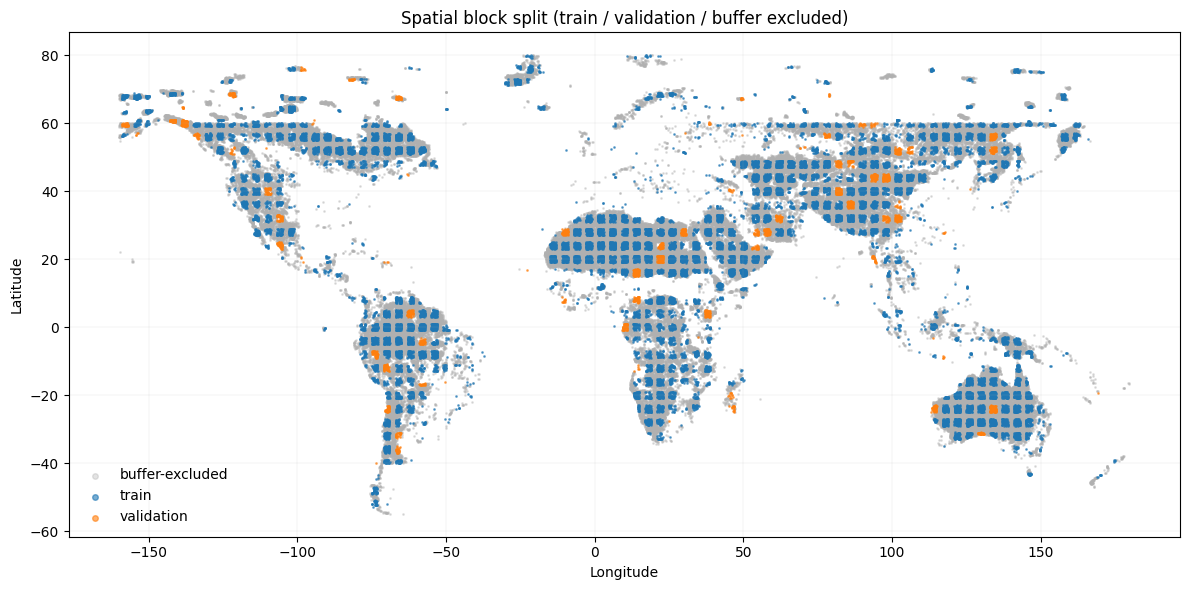

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(
    buffer_df["longitude"],
    buffer_df["latitude"],
    s=1,
    c="#b0b0b0",
    alpha=0.35,
    label="buffer-excluded",
)
plt.scatter(
    train_df["longitude"],
    train_df["latitude"],
    s=1,
    c="#1f77b4",
    alpha=0.6,
    label="train",
)
plt.scatter(
    val_df["longitude"],
    val_df["latitude"],
    s=1,
    c="#ff7f0e",
    alpha=0.6,
    label="validation",
)
plt.title("Spatial block split (train / validation / buffer excluded)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(markerscale=4, frameon=False)
plt.grid(True, linewidth=0.2, alpha=0.5)
plt.tight_layout()
plt.show()

In [32]:
climate = [
    "mean_annual_temp",
    "temp_seasonality",
    "annual_precip",
    "precip_seasonality",
]

aridity = [
    "aridity",
]

elevation = [
    "elevation",
    "slope",
]

terrain = [
    "tpi",
    "tri",
    "cti",
    "northness",
]

terrain_regional = [
    "tpi_regional",
]

soil = [
    "sand",
    "clay",
]

location = [
    "latitude",
    "longitude",
]

chelsa = [
    "chelsa_npp",
]

predictor_groups = {
    "climate": climate,
    "aridity": aridity,
    "elevation": elevation,
    "terrain": terrain,
    "terrain_regional": terrain_regional,
    "soil": soil,
    "location": location,
    "chelsa": chelsa,
}

all_predictors = [p for group in predictor_groups.values() for p in group]
PREDICTOR_VARIABLES = all_predictors

print(f"All predictors ({len(all_predictors)}): {all_predictors}")

All predictors (17): ['mean_annual_temp', 'temp_seasonality', 'annual_precip', 'precip_seasonality', 'aridity', 'elevation', 'slope', 'tpi', 'tri', 'cti', 'northness', 'tpi_regional', 'sand', 'clay', 'latitude', 'longitude', 'chelsa_npp']


In [ ]:
SELECTED_PREDICTORS = ["climate", "aridity", "soil", "location", "chelsa"]

# Allow either group names or explicit predictor names
if all(name in predictor_groups for name in SELECTED_PREDICTORS):
    SELECTED_VARIABLES = [p for name in SELECTED_PREDICTORS for p in predictor_groups[name]]
else:
    SELECTED_VARIABLES = list(SELECTED_PREDICTORS)

print(f"Selected predictors ({len(SELECTED_VARIABLES)}): {SELECTED_VARIABLES}")

Selected predictors (10): ['mean_annual_temp', 'temp_seasonality', 'annual_precip', 'precip_seasonality', 'aridity', 'sand', 'clay', 'latitude', 'longitude', 'chelsa_npp']


In [ ]:
import itertools

from joblib import Parallel, delayed


def prepare_xy(df, predictors, response):
    subset = df[predictors + [response]].dropna()
    X = subset[predictors].to_numpy()
    y = subset[response].to_numpy()
    return X, y


def fit_rf_model(train_df, predictors, response_var, n_jobs_model=1):
    X_train, y_train = prepare_xy(train_df, predictors, response_var)

    model = RandomForestRegressor(
        n_estimators=RF_NUM_TREES,
        min_samples_leaf=RF_MIN_LEAF_POPULATION,
        max_features=RF_VARIABLES_PER_SPLIT,
        bootstrap=True,
        max_samples=RF_BAG_FRACTION,
        random_state=RF_SEED,
        n_jobs=n_jobs_model,
        oob_score=True,
    )
    model.fit(X_train, y_train)
    return model


def evaluate(model, df, predictors, response_var):
    X, y = prepare_xy(df, predictors, response_var)
    pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    return rmse, r2, len(y)


def run_screening_combo(combo):
    predictors = [p for name in combo for p in predictor_groups[name]]
    label = "+".join(combo)

    model_mean = fit_rf_model(train_df, predictors, RESPONSE_VAR_MEAN, n_jobs_model=1)
    rmse_mean, r2_mean, n_mean = evaluate(model_mean, val_df, predictors, RESPONSE_VAR_MEAN)

    model_std = fit_rf_model(train_df, predictors, RESPONSE_VAR_STD, n_jobs_model=1)
    rmse_std, r2_std, n_std = evaluate(model_std, val_df, predictors, RESPONSE_VAR_STD)

    return {
        "groups": label,
        "n_predictors": len(predictors),
        "val_rmse_mean": rmse_mean,
        "val_r2_mean": r2_mean,
        "val_rmse_std": rmse_std,
        "val_r2_std": r2_std,
        "n_val_mean": n_mean,
        "n_val_std": n_std,
    }


all_combos = [
    combo
    for r in range(1, len(predictor_groups) + 1)
    for combo in itertools.combinations(predictor_groups.keys(), r)
]

screening_rows = Parallel(n_jobs=-1, prefer="processes", verbose=5)(
    delayed(run_screening_combo)(combo) for combo in all_combos
)

screening_df = pd.DataFrame(screening_rows)
screening_df = screening_df.sort_values("val_r2_mean", ascending=False)

print(f"Screened {len(screening_df):,} predictor-group combinations")
screening_df.head(10)

In [44]:
from joblib import Parallel, delayed

n_estimators_grid = [200, 500]
min_samples_leaf_grid = [10, 50, 100]
bag_fraction_grid = [0.5]
mtry_grid = [1, 2, 4]


def fit_rf_with_params(
    train_df,
    predictors,
    response_var,
    n_estimators,
    min_samples_leaf,
    mtry,
    bag_fraction,
    n_jobs_model=1,
):
    X_train, y_train = prepare_xy(train_df, predictors, response_var)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_features=mtry,
        bootstrap=True,
        max_samples=bag_fraction,
        random_state=RF_SEED,
        n_jobs=n_jobs_model,
        oob_score=True,
    )
    model.fit(X_train, y_train)
    return model


def run_tuning_combo(n_estimators, min_samples_leaf, mtry, bag_fraction):
    predictors = SELECTED_VARIABLES

    model_mean = fit_rf_with_params(
        train_df,
        predictors,
        RESPONSE_VAR_MEAN,
        n_estimators,
        min_samples_leaf,
        mtry,
        bag_fraction,
        n_jobs_model=1,
    )
    rmse_mean, r2_mean, n_mean = evaluate(model_mean, val_df, predictors, RESPONSE_VAR_MEAN)

    model_std = fit_rf_with_params(
        train_df,
        predictors,
        RESPONSE_VAR_STD,
        n_estimators,
        min_samples_leaf,
        mtry,
        bag_fraction,
        n_jobs_model=1,
    )
    rmse_std, r2_std, n_std = evaluate(model_std, val_df, predictors, RESPONSE_VAR_STD)

    return {
        "n_estimators": n_estimators,
        "min_samples_leaf": min_samples_leaf,
        "bag_fraction": bag_fraction,
        "mtry": mtry,
        "val_rmse_mean": rmse_mean,
        "val_r2_mean": r2_mean,
        "val_rmse_std": rmse_std,
        "val_r2_std": r2_std,
        "n_val_mean": n_mean,
        "n_val_std": n_std,
    }


hyperparam_rows = Parallel(n_jobs=-1, prefer="processes", verbose=5)(
    delayed(run_tuning_combo)(n_estimators, min_samples_leaf, mtry, bag_fraction)
    for n_estimators in n_estimators_grid
    for min_samples_leaf in min_samples_leaf_grid
    for mtry in mtry_grid
    for bag_fraction in bag_fraction_grid
)

hyperparam_df = pd.DataFrame(hyperparam_rows)
print(f"Tuned {len(hyperparam_df):,} hyperparameter combinations")
hyperparam_df.sort_values("val_r2_mean", ascending=False).head(10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:   31.4s remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   50.2s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:  1.3min remaining:   49.4s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  1.6min remaining:   19.5s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.0min finished


Tuned 18 hyperparameter combinations


,n_estimators,min_samples_leaf,bag_fraction,mtry,val_rmse_mean,val_r2_mean,val_rmse_std,val_r2_std,n_val_mean,n_val_std
2,200,10,0.5,4,1.480063e+06,0.939052,2273.701395,0.807431,2667,2667
11,500,10,0.5,4,1.489370e+06,0.938284,2269.217370,0.808190,2667,2667
1,200,10,0.5,2,1.516716e+06,0.935996,2245.374033,0.812200,2667,2667
10,500,10,0.5,2,1.523829e+06,0.935395,2248.088131,0.811746,2667,2667
14,500,50,0.5,4,1.576094e+06,0.930887,2365.766694,0.791521,2667,2667
5,200,50,0.5,4,1.576950e+06,0.930812,2364.118772,0.791811,2667,2667
9,500,10,0.5,1,1.613833e+06,0.927537,2353.002115,0.793765,2667,2667
0,200,10,0.5,1,1.621578e+06,0.926840,2353.443589,0.793687,2667,2667
4,200,50,0.5,2,1.623892e+06,0.926631,2406.959158,0.784198,2667,2667
13,500,50,0.5,2,1.633937e+06,0.925721,2410.861801,0.783497,2667,2667


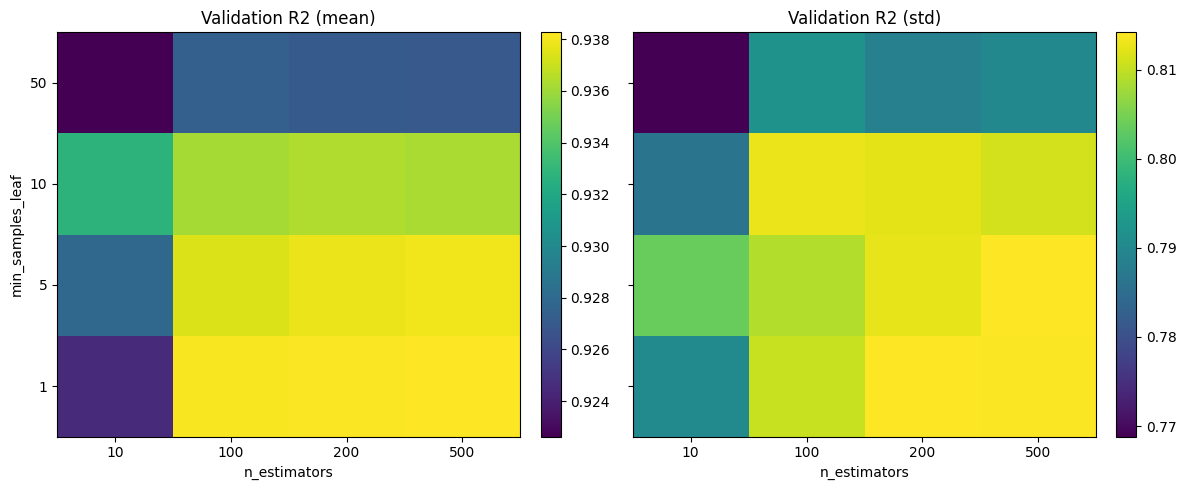

In [ ]:
summary = hyperparam_df.groupby("bag_fraction")[["val_r2_mean", "val_r2_std"]].max().reset_index()

best_bag_fraction = summary.sort_values("val_r2_mean", ascending=False).iloc[0]["bag_fraction"]

subset = hyperparam_df[hyperparam_df["bag_fraction"] == best_bag_fraction]

mean_pivot = subset.pivot(
    index="min_samples_leaf", columns="n_estimators", values="val_r2_mean"
).reindex(index=min_samples_leaf_grid, columns=n_estimators_grid)

std_pivot = subset.pivot(
    index="min_samples_leaf", columns="n_estimators", values="val_r2_std"
).reindex(index=min_samples_leaf_grid, columns=n_estimators_grid)

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

axes[0].plot(summary["bag_fraction"], summary["val_r2_mean"], marker="o", label="mean")
axes[0].plot(summary["bag_fraction"], summary["val_r2_std"], marker="o", label="std")
axes[0].set_title("Best validation R2 by bag fraction")
axes[0].set_xlabel("bag_fraction (bootstrap sample)")
axes[0].set_ylabel("Best validation R2")
axes[0].set_xticks(bag_fraction_grid)
axes[0].legend(frameon=False)

im0 = axes[1].imshow(mean_pivot, aspect="auto", origin="lower", cmap="viridis")
axes[1].set_title(f"Mean R2 (bag_fraction={best_bag_fraction})")
axes[1].set_xlabel("n_estimators")
axes[1].set_ylabel("min_samples_leaf")
axes[1].set_xticks(range(len(n_estimators_grid)))
axes[1].set_xticklabels(n_estimators_grid)
axes[1].set_yticks(range(len(min_samples_leaf_grid)))
axes[1].set_yticklabels(min_samples_leaf_grid)
fig.colorbar(im0, ax=axes[1], fraction=0.046, pad=0.04)

im1 = axes[2].imshow(std_pivot, aspect="auto", origin="lower", cmap="viridis")
axes[2].set_title(f"Std R2 (bag_fraction={best_bag_fraction})")
axes[2].set_xlabel("n_estimators")
axes[2].set_xticks(range(len(n_estimators_grid)))
axes[2].set_xticklabels(n_estimators_grid)
axes[2].set_yticks(range(len(min_samples_leaf_grid)))
axes[2].set_yticklabels(min_samples_leaf_grid)
fig.colorbar(im1, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
screening_df["withdem"] = screening_df.groups.str.contains("elevation")
pd.set_option("display.max_rows", None)
b = screening_df.sort_values("val_r2_mean", ascending=False)[
    ["groups", "val_r2_mean", "withdem"]
].copy()
b["val_r2_mean"] = b["val_r2_mean"].round(2)
b[~b.withdem]

,groups,val_r2_mean,withdem
181,climate+aridity+soil+location+chelsa,0.94,False
232,climate+aridity+terrain_regional+soil+location...,0.94,False
231,climate+aridity+terrain+soil+location+chelsa,0.94,False
251,climate+aridity+terrain+terrain_regional+soil+...,0.94,False
179,climate+aridity+terrain_regional+soil+chelsa,0.94,False
196,climate+terrain_regional+soil+location+chelsa,0.94,False
104,climate+aridity+soil+location,0.94,False
177,climate+aridity+terrain+location+chelsa,0.94,False
180,climate+aridity+terrain_regional+location+chelsa,0.94,False
126,climate+soil+location+chelsa,0.94,False
